<a href="https://colab.research.google.com/github/objectis/ai-pneumonia-detection/blob/master/detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing images

In [0]:
import os
import cv2
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

In [10]:
os.environ['KAGGLE_USERNAME'] = "xxx" 
os.environ['KAGGLE_KEY'] = "xxx" 
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:09<00:00, 150MB/s]
100% 1.15G/1.15G [00:09<00:00, 132MB/s]


Extracting downloaded images

In [0]:
from zipfile import ZipFile

zfile = ZipFile('chest_xray.zip', 'r')
zfile.extractall()
zfile.close()

defining file paths

In [52]:
from pathlib import Path

train_files = 'chest_xray/train'
test_files = 'chest_xray/test'
val_files = 'chest_xray/val'

CLASSES = ['PNEUMONIA','NORMAL']
def countFiles(path,categories):
  for cat in categories:
    folder = Path(path + "/" + cat + "/")
    tmp = list(folder.glob("*.jpeg"))
    print(path, "     ", cat, " : " ,len(tmp))
  return

countFiles(train_files,CLASSES)
countFiles(test_files,CLASSES)
countFiles(val_files,CLASSES)


chest_xray/train       PNEUMONIA  :  3875
chest_xray/train       NORMAL  :  1341
chest_xray/test       PNEUMONIA  :  390
chest_xray/test       NORMAL  :  234
chest_xray/val       PNEUMONIA  :  8
chest_xray/val       NORMAL  :  8


pre-processing data for the model using ImageDataGenerator

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

img_gen = ImageDataGenerator( shear_range = 0.2,
                              rescale = 1.0/255,
                              horizontal_flip = True)



In [76]:
to_train = img_gen.flow_from_directory(train_files, 
                                        target_size = (150, 150),
                                        classes = CLASSES,
                                        batch_size = 256, 
                                        shuffle = True, 
                                        class_mode = "binary")
to_test = img_gen.flow_from_directory(test_files, 
                                        target_size = (150, 150),
                                        classes = CLASSES,
                                        batch_size = 256, 
                                        shuffle = True, 
                                        class_mode = "binary")
to_val = img_gen.flow_from_directory(val_files, 
                                        target_size = (150, 150),
                                        classes = CLASSES,
                                        batch_size = 256, 
                                        shuffle = True, 
                                        class_mode = "binary")


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
from sklearn.utils.class_weight import compute_class_weight

y = to_train.classes
labels = np.unique(y)

train_class_weights = compute_class_weight("balanced", labels, y)

#Machine learning

In [0]:
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense

from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop


creating our own model on top of imagenet to work as classifier for xray lungs images

In [79]:
model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
model.trainable = False 

xray_model = Sequential([model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation = "relu"),
                      Dropout(0.3),
                      Dense(512, activation = "relu"),
                      Dropout(0.3),
                      Dense(256, activation = "relu"),
                      Dropout(0.3),
                      Dense(128, activation = "relu"),
                      Dropout(0.3),
                      Dense(1, activation = "sigmoid")])

xray_model.compile(RMSprop(), loss = "binary_crossentropy", metrics = ["accuracy"])
xray_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)              

now training the model

In [80]:
trained_model = xray_model.fit_generator(to_train, 
                                steps_per_epoch = len(to_train),
                                epochs = 10,
                                verbose = 1,
                                workers = 20,
                                validation_data = to_test, 
                                validation_steps = len(to_test),
                                class_weight = train_class_weights)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
21/21 [==============================] - 435s 21s/step - loss: 1.1517 - acc: 0.7596 - val_loss: 2.5462 - val_acc: 0.6250
Epoch 2/10
21/21 [==============================] - 377s 18s/step - loss: 0.4864 - acc: 0.7784 - val_loss: 3.3140 - val_acc: 0.3750
Epoch 3/10
21/21 [==============================] - 380s 18s/step - loss: 0.3704 - acc: 0.8372 - val_loss: 1.1735 - val_acc: 0.6875
Epoch 4/10
21/21 [==============================] - 381s 18s/step - loss: 0.3130 - acc: 0.8673 - val_loss: 2.2661 - val_acc: 0.6250
Epoch 5/10
21/21 [==============================] - 379s 18s/step - loss: 0.2938 - acc: 0.8771 - val_loss: 0.7667 - val_acc: 0.6538
Epoch 6/10
21/21 [==============================] - 379s 18s/step - loss: 0.2394 - acc: 0.8967 - val_loss: 0.8513 - val_acc: 0.6779
Epoch 7/10
21/21 [==============================] - 381s 18s/step - loss: 0.2232 - acc: 0.9066 - val_loss: 4.0656 

visualizing training process

In [81]:
print(trained_model.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


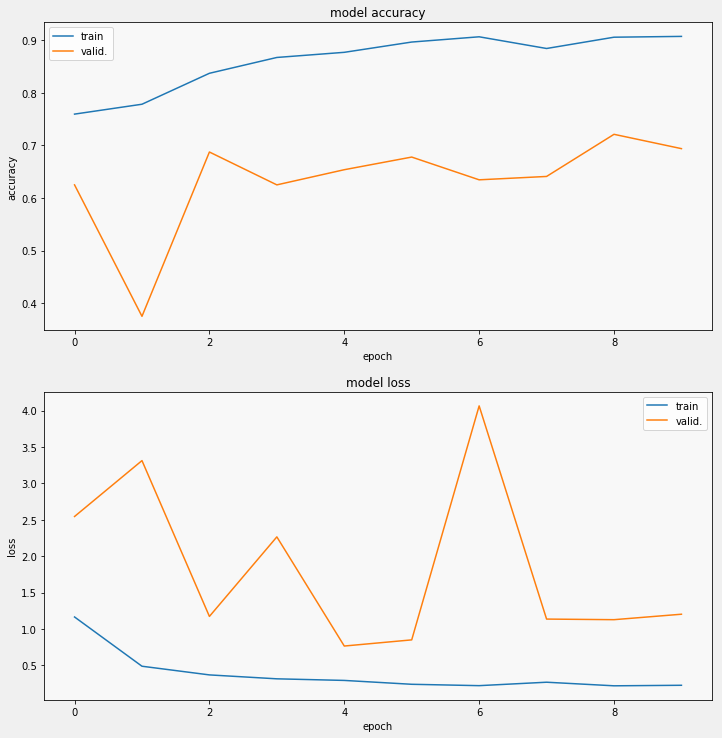

In [82]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

display_training_curves(trained_model.history['acc'], trained_model.history['val_acc'], 'accuracy', 211)
display_training_curves(trained_model.history['loss'], trained_model.history['val_loss'], 'loss', 212)

save the model

In [0]:
save_model(xray_model, "xray_after_10_epochs", overwrite = True, include_optimizer = True)

#Evaluate the results

In [87]:
y_pred = xray_model.predict_generator(to_val, steps=len(to_val), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=to_val.classes

1/1 [==============================] - 4s 4s/step


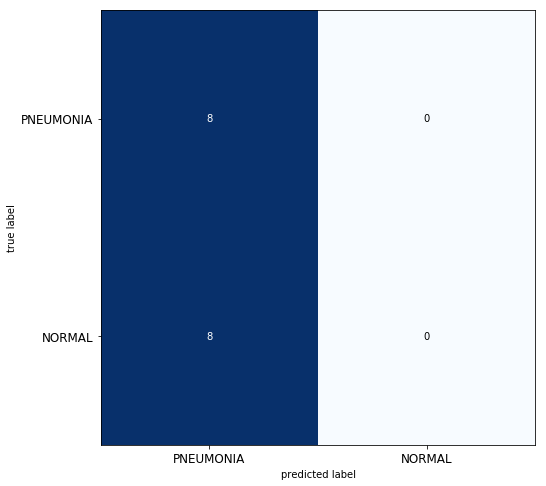

In [92]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

CM = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(CLASSES)), CLASSES, fontsize=12)
plt.yticks(range(len(CLASSES)), CLASSES, fontsize=12)
plt.show()